# Simple predictions of successful funding - logistic regression

### _Lukas Vlcek_


## Table of Contents

* [1. Introduction](#1.-Introduction)
* [2. Data setup](#2.-Data-setup)
    * [2.1 Filter out unneeded data](#2.1-Filter-out-unneeded-data)
    * [2.2 Create special features](#2.2-Create-special-features)
* [3. Modeling](#3.-Modeling)
    * [3.1 Select predictor and target features](#3.1-Select-predictor-and-target-features)
    * [3.2 Train-test split pandas dataframe](#3.2-Train-test-split-pandas-dataframe)
    * [3.3 Create a pipeline](#3.3-Create-a-pipeline)
        * [3.3.1 Define special classes](#3.3.1-Define-special-classes)
        * [3.3.2 Define pipeline structure](#3.3.2-Define-pipeline-structure)
    * [3.4 Define grid search](#3.4-Define-grid-search)
    * [3.5 Fit pipeline with best hyperparameters](#3.5-Fit-pipeline-with-best-hyperparameters)
    * [3.6 Predictions of project success](#3.6-Predictions-of-project-success)
    * [3.7 Model evaluation](#3.7-Model-evaluation)
    * [3.8 Compare predictions with staff picks](#3.8-Compare-predictions-with-staff-picks)
    * [3.9 Informative words in project names and blurbs](#3.9-Informative-words-in-project-names-and-blurbs)
* [4. Conclusions](#4.-Conclusions)

## 1. Introduction


Our task is to classify crowdfunding projects into 'successful' or 'failed' categories, with the ultimate goal of providing the predictions of success and failure that can compete with human assessment at negligible cost. A rough guidance of the model prediction limits is comparison with staff picks, i.e., the suggestions of the Kickstarter staff for promising projects. These picks are received by about 10% of the proposed projects after careful evaluation of the project content. Clearly, staff pick information is not available to the proposers. The model can be used by proposers to test different parameters of their proposal, such as goal amount or project naming and description.

Out of a number of available classification algorithms we chose the simple logistic regression for its speed, ease of interpretation, and flexibility. This flexibility is needed since we combine features of diverse datat types, including project category, country of origin, numerical goal amount, project name, and its description.

The model hyperparameters are optimized by cross-validation grid search, and the resulting model is evaluated in terms of accuracy, precision, recall, and the area under the receiver operating characteristic (ROC) curve. Direct comparison is also made with staff picks success rates.

## 2. Data setup

Notebook configuration

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Create a dataframe from a pre-processed CSV file and filter out uninformative features

In [2]:
target_path = '../data/processed'
report_path = '../reports'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)

### 2.1 Filter out unneeded data

In [3]:
df = df.drop(['disable_communication'], axis='columns')
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)
#df['dummy'] = 1
df['period'] = (df['launched_at'] >= '2014-06-01') & (df['launched_at'] < '2018-01-01')
df['succeeded'] = np.int_(df['state'] == 'successful')
df['staff_pick'] = np.int_(df['staff_pick'])
#df.sort_values('launched_at').loc[df.period]['launched_at'].shape

In [4]:
# counting words in project names and blurbs
df.loc[df['blurb'].isnull(), 'blurb'] = ''
df.loc[df['name'].isnull(), 'name'] = ''
df['blurb_wlen'] = df['blurb'].str.split().apply(len)
df['name_wlen'] = df['name'].str.split().apply(len)

In [5]:
# make new dataframes with new and old data
dfn = df.loc[df.period].copy()
dfo = df.loc[~df.period].copy()
dfn.shape, dfo.shape

((149007, 22), (89449, 22))

In [6]:
# take logarithm of goals
dfn['goal_log'] = np.log10(dfn['goal'].values)

In [7]:
# drop unwanted columns
dfm = dfn.drop(['usd_pledged','goal','state','slug','currency','deadline','state_changed_at','created_at','backers_count','spotlight','period'], axis=1).copy()

### 2.2 Create special features

In [8]:
# Divide goal_log feature into category-specific goals
for cat in dfm['cat_type'].unique():
    dfm['goal_'+cat] = dfm['goal_log']
    dfm.loc[dfm.cat_type != cat, 'goal_'+cat] = 0.0

dfm = dfm.drop('goal_log', axis=1)

In [9]:
# get dummies for country and category type
dfd = pd.get_dummies(dfm, columns=['country'], drop_first=True)
dfd = pd.get_dummies(dfd, columns=['cat_type'], drop_first=True)

## 3. Modeling

In [10]:
# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC

### 3.1 Select predictor and target features

In [11]:
# non-textual predictors
predictors_nt = []
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ]) # category types (dummy)
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'count' ]) # countries (dummy)
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'goal_' ]) # goals per category
predictors_nt.extend(['name_wlen']) # length of the project name

# textual predictors
predictors_text = []
predictors_text.extend(['name', 'blurb']) # words in name and blurb

# all predictors
predictors = predictors_nt + predictors_text

# target feature
target = ['succeeded']

### 3.2 Train-test split pandas dataframe

In [12]:
df_train=dfd.sample(frac=0.8,random_state=200)
df_test=dfd.drop(df_train.index)

In [13]:
# Training dataset
Xtrain = df_train[predictors]
ytrain = df_train[target].values.astype(np.int).flatten() 

# Testing dataset
Xtest = df_test[predictors]
ytest = df_test[target].values.astype(np.int).flatten() 

### 3.3 Create a pipeline

1. Textual features (name, blurb) will be separated for their individual treatment
2. Textual features will be individually vectorized
3. $\chi^2$ feature selection will be performed on the vectorized features.
4. The selected textual features will be combined with other features
5. Logistic regression will be applied. (LASSO regularization will further reduce the number of relevant features).



#### 3.3.1 Define special classes

Special classes are needed to separate, process, and join selected features from pandas dataframes.

In [14]:
# Define a selector class to be used in the main pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select a column from pandas dataframe.
    Transfrom returns pandas Series """
    
    def __init__(self, column=''):
        self.column = column

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.column]

In [15]:
class FeaturesSelector(BaseEstimator, TransformerMixin):
    """Select columns from pandas dataframe.
    Transform returns numpy array with one or more features"""
    
    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.columns].values

#### 3.3.2 Define pipeline structure

In [16]:
# Define the main pipeline (contains sub-pipelenes for text processing and feature selection)
pipeline = Pipeline([
    #('categories', FeatureUnion()) FeatureUnion based on catogories, make separate dataframes for each category
    ('union', FeatureUnion(
        transformer_list=[
            ('name', Pipeline([
                ('selector', ColumnSelector('name')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(score_func=chi2, k=2000))
            ])),
            ('blurb', Pipeline([
                ('selector', ColumnSelector('blurb')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(score_func=chi2, k=2000))
            ])),
            ('rest', Pipeline([
                ('selector', FeaturesSelector(predictors_nt)),
            ]))
        ])),
    ('logreg', LogisticRegression(penalty='l2', C=0.2))
])

### 3.4 Define grid search

Find optimal hyperparameters

In [22]:
# parameter grid to explore
param_grid = {
        'logreg__C': [0.1, 0.2, 0.3, 0.4, 0.5],
        #'logreg__penalty': ['l1', 'l2'],
        'union__name__reduce_dim__k' : [1000, 2000],
        'union__blurb__reduce_dim__k' : [1000, 2000],
        #'union__name__reduce_dim__score_func' : [chi2, mutual_info_classif]
}
# alphabetically sorted parameters
grid_list = sorted(param_grid)

In [23]:
# Define grid search object
grid = GridSearchCV(pipeline, cv=3, param_grid=param_grid)

### 3.5 Fit pipeline with best hyperparameters

In [24]:
# perform fit
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('name', Pipeline(steps=[('selector', ColumnSelector(column='name')), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logreg__C': [0.1, 0.2, 0.3, 0.4, 0.5], 'union__name__reduce_dim__k': [1000, 2000], 'union__blurb__reduce_dim__k': [1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
# Identify optimal parameters
mean_scores = np.array(grid.cv_results_['mean_test_score']).reshape(5,2,2)
print('Maximum score:', mean_scores.max())
best_index = np.unravel_index(np.argmax(mean_scores, axis=None), mean_scores.shape)
print('Best hyperparameters:')
for i, j in enumerate(best_index):
    print(' ', grid_list[i],':', param_grid[grid_list[i]][j])

Maximum score: 0.751237353824
Best hyperparameters:
  logreg__C : 0.2
  union__blurb__reduce_dim__k : 2000
  union__name__reduce_dim__k : 2000


### 3.6 Predictions of project success

In [26]:
y_pred = grid.predict(Xtest)
y_pred_prob = grid.predict_proba(Xtest)

### 3.7 Model evaluation

In [27]:
print('Accuracy on the training data:', grid.score(Xtrain, ytrain))
print('Accuracy on the testing data:', grid.score(Xtest, ytest))

Accuracy on the training data: 0.776395483449
Accuracy on the testing data: 0.751518405423


In [28]:
print("Classification report\n---------------------")
print(classification_report(ytest, y_pred))

Classification report
---------------------
             precision    recall  f1-score   support

          0       0.77      0.84      0.81     18386
          1       0.70      0.60      0.65     11415

avg / total       0.75      0.75      0.75     29801



AUC: 0.82710372482


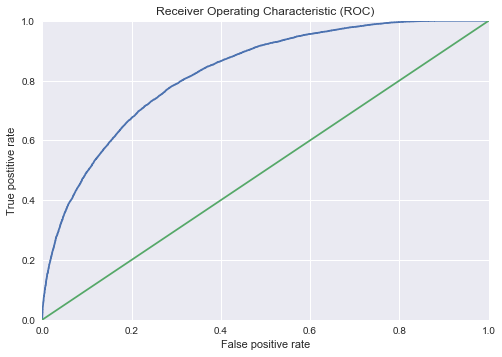

In [29]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate')
plt.ylabel('True postitive rate')
plt.title("Receiver Operating Characteristic (ROC)")
print('AUC:', roc_auc_score(ytest, y_pred_prob[:,1]))
plt.savefig('../reports/figures/roc.png')

### 3.8 Compare predictions with staff picks

Staff picks can be considered as optimizing precision. The data shows precision of 0.86, with recall of 0.21.

Setting the threshold to 10% selected projects, we can predict precision and recall of staff picks from our model.

In [30]:
# Find threshold for 10% selection rate
#thresh = np.linspace(0.0, 1.0, 101)
#for t in thresh:
#    print(t, np.sum(y_pred_prob[:,1] > t)/y_pred_prob.shape[0])

y_predx = np.int_(y_pred_prob[:,1] > 0.785)
print('Fraction of picked projects at threshold 0.785:', np.sum(y_predx)/y_predx.shape[0])

Fraction of picked projects at threshold 0.785: 0.100902654273


In [31]:
print(classification_report(ytest, y_predx))

             precision    recall  f1-score   support

          0       0.67      0.98      0.80     18386
          1       0.86      0.23      0.36     11415

avg / total       0.74      0.69      0.63     29801



Our model picks based on historical data match almost exactly the precision (0.86) with higher recall (0.23) of real staff picks, which are not available to proposers.

### 3.9 Informative words in project names and blurbs

Identify 100 words that result in the highest chi2 score in feature selection. (More words are usually needed for better classification.)

In [32]:
word_pipe = {}
cols = ['name','blurb']
for col in cols:
    word_pipe[col]  = Pipeline([('selector', ColumnSelector(col)),
                                ('vectorizer', CountVectorizer()),
                                ('reduce_dim', SelectKBest(score_func=chi2, k=100))
                      ])

In [33]:
for col in cols:
    word_pipe[col].fit(Xtrain, ytrain)
    indices = np.nonzero(word_pipe[col].named_steps['reduce_dim'].get_support())
    voca = word_pipe[col].named_steps['vectorizer'].vocabulary_
    print(f'\n{len(indices[0])} most informative words from project {col}s\n')
    print([key for key, value in voca.items() if value in indices[0]])


100 most informative words from project names

['terrain', 'the', 'by', 'album', 'playing', 'cards', 'presents', 'board', 'game', 'mobile', 'comic', 'book', 'vol', 'canceled', 'app', 'new', 'of', 'film', 'short', 'com', 'dance', 'enamel', 'pins', 'restaurant', 'business', 'my', 'most', 'burning', '2014', 'novel', 'debut', 'ep', 'watch', 'youtube', 'brand', 'steampunk', 'about', 'minimalist', '2016', 'record', 'roleplaying', 'social', 'apparel', 'volume', 'watches', 'food', 'miniatures', 'bike', 'bag', 'edinburgh', 'edition', 'tarot', 'full', 'length', 'fantasy', 'rpg', 'issue', 'pin', '2017', 'network', 'fashion', 'tabletop', 'coloring', 'dice', 'clothing', 'sci', 'fi', 'season', 'nudes', 'documentary', 'dungeon', 'wallet', 'truck', 'set', 'pens', 'backpack', 'card', '5e', 'online', 'website', 'titanium', 'anthology', 'media', 'vinyl', 'pen', 'carbon', 'sports', 'miniature', 'thesis', 'plush', 'fringe', 'zine', '28mm', 'residency', 'news', 'cthulhu', 'bbq', 'carry', 'edc', 'pathfinder

The most important words are highly indicative of the category, so conditioning on category (have predictors for each category), may select a smaller number of words adding truly new information. Interestingly, there are many usual stop-words selected.

## 4. Conclusions

The resulting model achieves around 75% accuracy on the testing data and value of ~0.83 for the area under ROC curve. The latter characteristic is often considered 'good'. Also, this simple model can match or exceed the precision and recall characteristics of staff picks, which are based on evaluation of the proposal content.

If needed, the model could be further improved by accounting for correlations between category and project name/description. A look at the most informative words in the project name/description suggest that they are highly correlated with the category, and also contain many common words, such as 'the', be', etc., which by themselves do not contain information about the underlying project. A more complete natural language analysis could be expected to improve the current model predictions.